# Bayesian Semi-parametric Survival Analysis Notebook

by Michael Wamberg & Bjarke Hastrup

# The equivalent poisson model

Survival function:  $$S(t)=exp\left(-\int_0^t \lambda(u)du\right)$$

Cox proportional hazard:$$\lambda_{ij} =\lambda_{j} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta})$$

Likelihood contribution from i'th individual, who dies or is censored in j'th time interval:    $\nu_i=1$ for death, 0 otherwise

\begin{align*}
L_i(\boldsymbol{\beta},\boldsymbol{\lambda} | D_{i})
&= (\lambda_{j} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}))^{\delta_{ij}\nu_{i}} \exp \left\{ - \delta_{ij} \left[ \lambda_{j}(y_{i} - s_{j-1}) + \sum^{j-1}_{g=1} \lambda_{g}(s_{g} - s_{g-1}) \right] \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}) \right\}\\
 &= \prod^{j}_{g=1} \exp \left\{ - \lambda_{g} t_{i,g} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}) \right\} (\lambda_{g} t_{i,g} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}))^{\delta_{i,g} \nu_{i}} \big/ (\delta_{i,g} \nu_{i})!\\
\end{align*}

We recognize this as poisson likelihood: $\frac{\mu e^{-\mu}}{k!}$.

$$
\log(\mu_{i,g})= \log(t_{i,g}) + \log(\lambda_{g}) + \mathbf{x}_{i}^{T}\boldsymbol{\beta}\\
$$


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels
import pystan
from sklearn import preprocessing
#from pandas_ods_reader import read_ods

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

#### Importing dataset

In [2]:
df = pd.read_csv('all_leagues_collected_clean.csv')
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,goal_time_h,goal_time_a,finished,red_cards_h,red_cards_a,BbAv>2.5,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,"3,83",91,94,NaN,NaN,2.03,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,"24,91",NaN,95,NaN,NaN,1.98,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,NaN,"41,80",95,NaN,NaN,1.95,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,NaN,"34,45,80",93,NaN,NaN,1.98,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,11,"8,18",95,NaN,NaN,2.01,4.74,3.53,1.89


#### Data description:

Div = League Division

Date = Match Date (dd/mm/yy)

HomeTeam = Home Team

AwayTeam = Away Team

FTHG = Full Time Home Team Goals

FTAG = Full Time Away Team Goals

goal_time_h = times for home team goals

goal_time_a = times for away team goals

finished = played number of minutes

red_cars_h = red card times for the home team

red_cards_a = red card times for the away team

BbAv>2.5 = Betbrain average over 2.5 goals

PSCH = Pinnacle home win odds

PSCD = Pinnacle draw odds

PSCA = Pinnacle away win odds

In [3]:
df.dtypes

Div             object
Date            object
HomeTeam        object
AwayTeam        object
FTHG             int64
FTAG             int64
goal_time_h     object
goal_time_a     object
finished         int64
red_cards_h     object
red_cards_a     object
BbAv>2.5       float64
PSCH           float64
PSCD           float64
PSCA           float64
dtype: object

Matches per league

In [4]:
matches_por = df[df['Div'].str.contains("P1")].reset_index()
matches_eng = df[df['Div'].str.contains("E0")].reset_index()
matches_ita = df[df['Div'].str.contains("I1")].reset_index() 

print("The dataset contains", len(matches_por), "matches from Portugal,", len(matches_eng), "matches from England and", len(matches_ita), "matches from Italy")

The dataset contains 612 matches from Portugal, 760 matches from England and 760 matches from Italy


#### Visualization of data

The average number of goals from the 2017/18 and 2018/19 seasons in Portugal: 2.6993464052287583
The average number of goals from the 2017/18 and 2018/19 seasons in England: 2.75
The average number of goals from the 2017/18 and 2018/19 seasons in Portugal: 2.6789473684210527


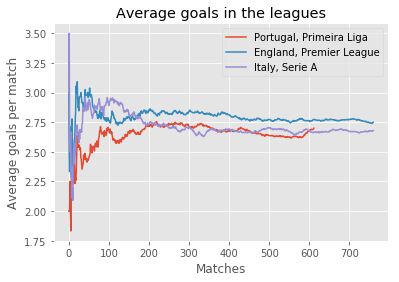

In [5]:
FTG_por = matches_por["FTHG"] + matches_por["FTAG"] # total number of goals per match in Portugal
FTG_eng = matches_eng["FTHG"] + matches_eng["FTAG"] # total number of goals per match in England
FTG_ita = matches_ita["FTHG"] + matches_ita["FTAG"] # # total number of goals per match in Italy

FTG_por_cumsum, FTG_eng_cumsum, FTG_ita_cumsum = [], [], []
FTG_por_av, FTG_eng_av, FTG_ita_av = [], [], []

for i in range(len(FTG_por)):
    FTG_por_cumsum.append(FTG_por[i])
    FTG_por_av.append(np.sum(FTG_por_cumsum) / (i+1))

for i in range(len(FTG_eng)):
    FTG_eng_cumsum.append(FTG_eng[i])
    FTG_eng_av.append(np.sum(FTG_eng_cumsum) / (i+1))

    FTG_ita_cumsum.append(FTG_ita[i])
    FTG_ita_av.append(np.sum(FTG_ita_cumsum) / (i+1))
    
plt.title("Average goals in the leagues")
plt.ylabel("Average goals per match")
plt.xlabel("Matches")
plt.plot(FTG_por_av, label="Portugal, Primeira Liga")
plt.plot(FTG_eng_av, label="England, Premier League")
plt.plot(FTG_ita_av, label="Italy, Serie A")
plt.legend()

print("The average number of goals from the 2017/18 and 2018/19 seasons in Portugal:", np.mean(FTG_por))
print("The average number of goals from the 2017/18 and 2018/19 seasons in England:", np.mean(FTG_eng))
print("The average number of goals from the 2017/18 and 2018/19 seasons in Portugal:", np.mean(FTG_ita))

# Data preprocessing

Here we are extracting the times for the first goal

In [6]:
# start by recording the NaN values
ikke_nan_h = df['goal_time_h'].isnull() == False
ikke_nan_a = df['goal_time_a'].isnull() == False

# function for finding second goal
def second_smallest(goal_times):
    m1, m2 = float('inf'), float('inf')
    for x in goal_times:
        if x <= m1:
            m1, m2 = x, m1
        elif x < m2:
            m2 = x
    return m2

In [7]:
df['t'] = df['finished'] # for first goal times
df['t2'] = df['finished'] # for second goal times

df['dead'] = 0 # for censoring related to first goal
df['dead2'] = 0 # for censoring related to second goal

df['t1_h'] = df['finished'] # first goal times home
df['t1_a'] = df['finished'] # first goal times away
df['t2_h'] = df['finished'] # second goal times home
df['t2_a'] = df['finished'] # second goal times away

for i in range(len(df)):
    if ikke_nan_h[i] == True:
        df.loc[i,'dead'] = 1
        df.loc[i,'dead2'] = 1
        string = df.loc[i,'goal_time_h']
        try:
            substr = string[:string.index(",")]
            df.loc[i, 't1_h'] = float(substr)
        except:
            substr = df.loc[i,'goal_time_h']
            df.loc[i,'t1_h'] = float(substr)
    
    if ikke_nan_a[i] == True:
        df.loc[i,'dead'] = 1
        string = df.loc[i,'goal_time_a']
        try:
            substr = string[:string.index(",")]
            df.loc[i,'t1_a'] = float(substr)
        except:
            substr = df.loc[i,'goal_time_a']
            df.loc[i,'t1_a'] = float(substr)
            
    # adding first goal times
    first_goal = min(df.loc[i,'t1_h'], df.loc[i,'t1_a'])
    
    if first_goal < df.loc[i,'t']:
        df.loc[i,'t'] = first_goal
    
    # adding second goal times
    if df.loc[i,'dead'] == 1 and ikke_nan_h[i] == True:        
        time_split_h = df.loc[i, 'goal_time_h'].split(",")
        n_goals_h = len(time_split_h)
        
        if n_goals_h > 1:
            df.loc[i,'t2_h'] = float(time_split_h[1])
    
    if df.loc[i,'dead'] == 1 and ikke_nan_a[i] == True:        
        time_split_a = df.loc[i, 'goal_time_a'].split(",")
        n_goals_a = len(time_split_a)
        
        if n_goals_a > 1:
            df.loc[i,'t2_a'] = float(time_split_a[1])    
    
    second_goal = second_smallest([df.loc[i, 't1_h'], df.loc[i, 't1_a'], df.loc[i, 't2_h'], df.loc[i, 't2_a']])
    
    if second_goal < df.loc[i,'t2']:
        df.loc[i,'t2'] = second_goal

    if df.loc[i,'t2'] == df.loc[i,'finished']:
        df.loc[i, 'dead2'] = 0

In [8]:
df.head(25)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,goal_time_h,goal_time_a,finished,red_cards_h,...,PSCD,PSCA,t,t2,dead,dead2,t1_h,t1_a,t2_h,t2_a
0,E0,10/08/2018,Man United,Leicester,2,1,"3,83",91,94,NaN,...,4.07,7.69,3.0,83.0,1,1,3.0,91.0,83.0,94.0
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,"24,91",NaN,95,NaN,...,3.61,4.70,24.0,91.0,1,1,24.0,95.0,91.0,95.0
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,NaN,"41,80",95,NaN,...,3.38,2.90,41.0,80.0,1,0,95.0,41.0,95.0,80.0
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,NaN,"34,45,80",93,NaN,...,3.95,1.58,34.0,45.0,1,0,93.0,34.0,93.0,45.0
4,E0,11/08/2018,Newcastle,Tottenham,1,2,11,"8,18",95,NaN,...,3.53,1.89,8.0,11.0,1,1,11.0,8.0,95.0,18.0
5,E0,11/08/2018,Watford,Brighton,2,0,"35,54",NaN,94,NaN,...,3.08,3.22,35.0,54.0,1,1,35.0,94.0,54.0,94.0
6,E0,11/08/2018,Wolves,Everton,2,2,"44,8","17,67",94,NaN,...,3.23,3.32,17.0,17.0,1,1,44.0,17.0,8.0,67.0
7,E0,12/08/2018,Arsenal,Man City,0,2,NaN,"14,64",94,NaN,...,4.13,1.81,14.0,64.0,1,0,94.0,14.0,94.0,64.0
8,E0,12/08/2018,Liverpool,West Ham,4,0,"19,45,53,88",NaN,93,NaN,...,6.95,12.00,19.0,45.0,1,1,19.0,93.0,45.0,93.0
9,E0,12/08/2018,Southampton,Burnley,0,0,NaN,NaN,95,NaN,...,3.19,4.65,95.0,95.0,0,0,95.0,95.0,95.0,95.0


Now we can look at when the first goal is generally scored in the three leagues

Text(0.5, 0, 'Minutes')

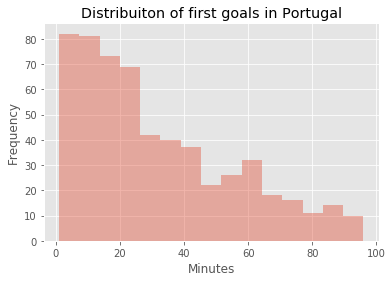

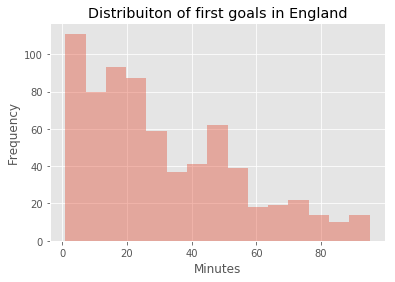

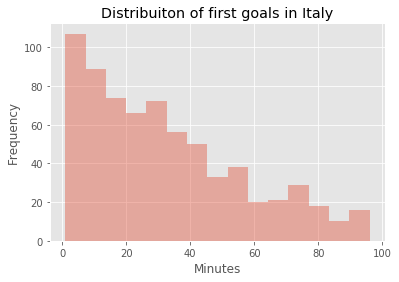

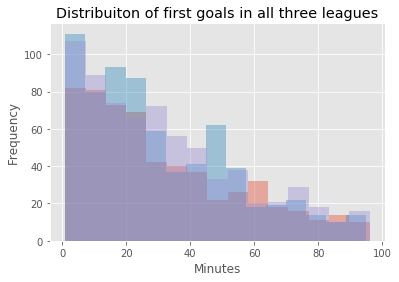

In [9]:
matches_por = df[df['Div'].str.contains("P1")].reset_index()
matches_eng = df[df['Div'].str.contains("E0")].reset_index()
matches_ita = df[df['Div'].str.contains("I1")].reset_index()

nondead_por = matches_por['dead'] == 1
nondead_eng = matches_eng['dead'] == 1
nondead_ita = matches_ita['dead'] == 1

matches_por_nondead = matches_por[nondead_por]
matches_eng_nondead = matches_eng[nondead_eng]
matches_ita_nondead = matches_ita[nondead_ita]

plt.title("Distribuiton of first goals in Portugal")
plt.hist(matches_por_nondead['t'], bins=15, alpha=0.4)
plt.ylabel("Frequency")
plt.xlabel("Minutes")

plt.figure()
plt.title("Distribuiton of first goals in England")
plt.hist(matches_eng_nondead['t'], bins=15, alpha=0.4)
plt.ylabel("Frequency")
plt.xlabel("Minutes")

plt.figure()
plt.title("Distribuiton of first goals in Italy")
plt.hist(matches_ita_nondead['t'], bins=15, alpha=0.4)
plt.ylabel("Frequency")
plt.xlabel("Minutes")

plt.figure()
plt.title("Distribuiton of first goals in all three leagues")
plt.hist(matches_por_nondead['t'], bins=15, alpha=0.4)
plt.hist(matches_eng_nondead['t'], bins=15, alpha=0.4)
plt.hist(matches_ita_nondead['t'], bins=15, alpha=0.4)
plt.ylabel("Frequency")
plt.xlabel("Minutes")

Next we setup an skill feature based on the available odds in the dataset. To do this most accurately, we must pay attention to how the bookmaker (Pinnacle) apply his margin. The odds quoted by Pinnacle on some match is related to the probabilities of the possible outcomes in this match. These probabilities do not add to 100% though, and the amount by which they exceed 100% constitutes Pinnacle's margin. Removing this margin should therefore reveal their true assessment of the match. Typically a greater margin is applied to the higher odds, since people prefer longshots compared to short odds - this is known as the favourite-longshot bias. Thus, the margin is removed relative to the size of odds

In [10]:
def normalise_odds(PSCH, PSCD, PSCA):
    """
    Normalise odds to probabilities by odds margin.
    margin weights in proportion to the size of the odds
    """
    probs = [1. / odds for odds in (PSCH, PSCD, PSCA)]
    margin = sum(probs)-1.
    trueo = [1./(3.* odds/(3.-margin*odds)) for odds in (PSCH, PSCD, PSCA)]
    
    return trueo

In [11]:
odds_columns = ['PSCH', 'PSCD', 'PSCA']

probabilities = df[odds_columns].apply(lambda row: normalise_odds(**row), axis=1)
cols = list(['home_win_prob','draw','away_win_prob'])
probabilities = pd.DataFrame(probabilities.values.tolist(), columns=cols)

df = df.merge(
    probabilities,
    left_index=True,
    right_index=True,
    suffixes=['', '_prob']
)

In [12]:
# To confirm our added columns
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,goal_time_h,goal_time_a,finished,red_cards_h,...,t2,dead,dead2,t1_h,t1_a,t2_h,t2_a,home_win_prob,draw,away_win_prob
0,E0,10/08/2018,Man United,Leicester,2,1,"3,83",91,94,NaN,...,83.0,1,1,3.0,91.0,83.0,94.0,0.638194,0.238733,0.123072
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,"24,91",NaN,95,NaN,...,91.0,1,1,24.0,95.0,91.0,95.0,0.524685,0.269779,0.205536
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,NaN,"41,80",95,NaN,...,80.0,1,0,95.0,41.0,95.0,80.0,0.374224,0.288403,0.337373
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,NaN,"34,45,80",93,NaN,...,45.0,1,0,93.0,34.0,93.0,45.0,0.130056,0.245099,0.624846
4,E0,11/08/2018,Newcastle,Tottenham,1,2,11,"8,18",95,NaN,...,11.0,1,1,11.0,8.0,95.0,18.0,0.203185,0.275500,0.521315


Then we can look at how these probabilities match up with the actual results

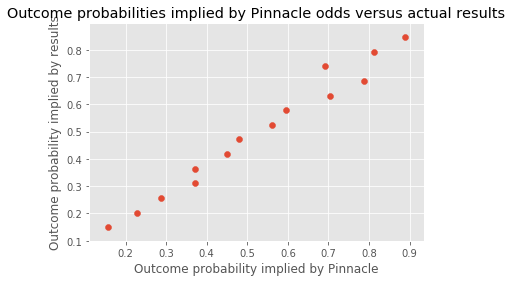

In [13]:
# Add full time result column
for i in range(len(df)):
    if df['FTHG'][i] > df['FTAG'][i]:
        df.loc[i,'FTR'] = 'H'
    elif df['FTHG'][i] < df['FTAG'][i]:
        df.loc[i,'FTR'] = 'A'
    else:
        df.loc[i,'FTR'] = 'D'
        
# discretize win probabilties
prob_range = np.linspace(0.15, 0.90, num=15)
prob_count = np.empty(len(prob_range))
win_count = np.empty(len(prob_range))

for i in range(len(df)):
    for j in range(len(prob_range)-1):
        if df['home_win_prob'][i] > prob_range[j] and df['home_win_prob'][i] < prob_range[j+1]:
            prob_count[j] += 1
            df.loc[i,'home_win_prob_disc'] = prob_range[j]        
            
        elif df['away_win_prob'][i] > prob_range[j] and df['away_win_prob'][i] < prob_range[j+1]:
            prob_count[j] += 1
            df.loc[i,'away_win_prob_disc'] = prob_range[j]

for i in range(len(df)):
    for j in range(len(prob_range)-1):
        if df['home_win_prob_disc'][i] == prob_range[j] and df['FTR'][i] == 'H':
            win_count[j] += 1
        elif df['away_win_prob_disc'][i] == prob_range[j] and df['FTR'][i] == 'A':
            win_count[j] += 1   
            
# Outcome probability implied by results
OPIR = win_count / prob_count

plt.title("Outcome probabilities implied by Pinnacle odds versus actual results")
plt.xlabel("Outcome probability implied by Pinnacle")
plt.ylabel("Outcome probability implied by results")
plt.scatter(OPIR[:-1], prob_range[:-1])            

In order to avoid a _absolute value function-looking_-function, we create the skill gap feature below,  which goes to zero for two teams that are considered equally likely to win the match.

In [ ]:
df['skill_gap'] = np.abs(df['home_win_prob'] - df['away_win_prob'])

Let us look at the first goal times versus this skill gap

In [ ]:
df_nondead_idx = df['dead'] == 1
df_nondead = df[df_nondead_idx]
df_nonead_sorted_sg = df_nondead.sort_values(by=['skill_gap'])

plt.title("First goal times versus skill gap")
plt.ylabel("First goal time")
plt.xlabel("Skill gap")
plt.scatter(df_nonead_sorted_sg['skill_gap'],df_nonead_sorted_sg['t'], s=10)

Forcing our skill gap to be within range [-1,1]

In [ ]:
scaler = preprocessing.StandardScaler()
df.loc[:, 'skill_gap'] = scaler.fit_transform(np.asarray(df.loc[:, 'skill_gap']).reshape(-1, 1))
df.dead = df.dead.astype(int)
df.head()

In [ ]:
n_patients = df.shape[0]
patients = np.arange(n_patients)

In [ ]:
df_sort = df.sort_values(by=['t'])

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
blue, _, red = sns.color_palette()[:3]
ax.hlines(patients[df_sort.dead.values == 0], 0, df_sort[df_sort.dead.values == 0].t,
          color=blue, label='Censored');
ax.hlines(patients[df_sort.dead.values == 1], 0, df_sort[df_sort.dead.values == 1].t,
          color=red, label='Uncensored');

ax.set_xlim(left=0);
ax.set_xlabel('Survival time [days]');
ax.set_ylim(-0.25, n_patients + 0.25);
ax.legend(loc='top right');

In [ ]:
interval_length = 4
interval_bounds = np.arange(0, df.t.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df[df.dead == 1].t.values, bins=interval_bounds,
        color=red, alpha=0.5, lw=0,
        label='Uncensored');
ax.hist(df[df.dead == 0].t.values, bins=interval_bounds,
        color=blue, alpha=0.5, lw=0,
        label='Censored');
ax.set_xlim(0, interval_bounds[-1]);
ax.set_xlabel('Survival time [days]');
ax.set_yticks([0, 1, 2, 3]);
ax.set_ylabel('Number of observations');
ax.legend();

In [ ]:
last_period = np.floor((df.t - 0.01) / interval_length)

death = np.zeros((n_patients, n_intervals))
death[patients, last_period.astype(int)] = df.dead

In [ ]:
exposure = np.greater_equal.outer(df.t, interval_bounds[:-1]) * interval_length
exposure[patients, last_period.astype(int)] = df.t - interval_bounds[last_period.astype(int)]

In [ ]:
death_dat = {'N': len(df),
             'n_intervals':  n_intervals,
             #'death_array': death_array, 
             #'meta_array':  meta_array, 
             #'expo_array':  expo_array}
             'death':     death.astype(int),
             'skill_gap':   np.asarray(df.skill_gap),
             'exposure':  exposure}

In [ ]:
#death_array = np.matrix.flatten(death)
#expo_array = np.matrix.flatten(exposure)
#therapy_array = np.asarray(df.therapy)
#meta_array = np.tile(meta_array, (n_intervals, 1))
#meta_array = meta_array.flatten('F')

In [ ]:
death_array = np.matrix.flatten(death).astype(int)

In [ ]:
expo_array = np.matrix.flatten(exposure)

In [ ]:
skill_gap_array = np.asarray(df.skill_gap)
skill_gap_array = np.tile(skill_gap_array, (n_intervals, 1))
skill_gap_array = skill_gap_array.flatten('F')

In [ ]:
base_id = np.arange(1,n_intervals+1)
print(str(base_id.shape))
base_id = np.tile(base_id, len(df))
base_id

In [ ]:
death_dat2 ={'N':      len(df),
             'N_tot':  len(death_array),
             'T':      n_intervals,
             'M': 1,
             'base_id': base_id,
             'death_array':   death_array, 
             'x': skill_gap_array, 
             'expo':    expo_array}

In [ ]:
expo_new  = expo_array[expo_array > 0]
N_tot_new = len(expo_new)
base_id_new = base_id[expo_array > 0]
death_array_new = death_array[expo_array > 0]
skill_gap_array_new = skill_gap_array[expo_array > 0]

In [ ]:
death_dat3 ={'N':      len(df),
             'N_tot':  N_tot_new,
             'T':      n_intervals,
             'M': 1,
             'base_id': base_id_new,
             'death_array':   death_array_new, 
             'x': skill_gap_array_new, 
             'expo':    expo_new}

In [ ]:
death_dat3['base_id']

Stan code for equivalent poisson model using independent vague priors $\lambda_j \sim gamma(0.1,0.1)$. 
For covariate coeffient we have chosen $beta \sim normal(0,2).$

In [ ]:
survival_model="""
data {
  int<lower=1> N;          // number of individuals
  int<lower=1> N_tot;      // total number of pseudo poisson observations
  int<lower=1> T;          // number of time intervals
  //int<lower=0> M;        // number of covariates
  int<lower=0, upper=T> base_id[N_tot];  // time interval index for each pseudo obs.
  
  int<lower=0, upper=1> death_array[N_tot];    // 1 for observed death, 0 all other cases
  vector[N_tot] x;                             // covariates

  vector<lower=0>[N_tot] expo;  // exposure time (time alive) in each interval
}

transformed data {
  vector[N_tot] log_expo = log(expo);  // log-duration for each timepoint
}
parameters {
  real beta;                       // regression coefficient
  vector<lower=0>[T] lambda0;  // baseline hazard for each timepoint t
}
model {
  beta ~ normal(0, 1);
  lambda0 ~ gamma(0.01,0.1);
  for (n_tot in 1:N_tot) {
    death_array[n_tot] ~ poisson_log(log(lambda0[base_id[n_tot]]) + log_expo[n_tot]   + x[n_tot] * beta );
  }
  
}
generated quantities {
  vector[N] log_lik;
  int n; 
  n = 1;
  log_lik = rep_vector(0,N);
  
  // log_lik for loo-psis
  for (n_tot in 1:N_tot) { 
      log_lik[n] += poisson_log_lpmf(death_array[n_tot]| log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta );
      
      // increment individual count if next time interval comes before the current 
      // only because of bad programming
      if (n_tot > 1){
          if (base_id[n_tot] <= base_id[n_tot-1]){
              n += 1;  
          }
      }
  }
}
"""

In [ ]:
sm = pystan.StanModel(model_code=survival_model);

In [ ]:
fit = sm.sampling(data=death_dat3, algorithm="HMC", seed=10, iter=500, chains=4, warmup=100)

In [ ]:
fit

In [ ]:
aa = fit.extract()

# Conclusion: The test therapy reduces the average hazard by approximately 8%

In [ ]:
np.exp(aa['beta'].mean())

In [ ]:
fit.traceplot('beta');

# Psis-loo

In [ ]:
from psis import psisloo

In [ ]:
np.shape(aa['log_lik'])

In [ ]:
log_likelihood1 = aa['log_lik'].reshape(1600,-1)

In [ ]:
loo, loos, ks = psisloo(log_likelihood1)

In [ ]:
np.std(loos)

In [ ]:
# estimated number of effective parameters
computed_lppd = np.sum(np.log(np.mean(np.exp(log_likelihood1),axis=0)));
pl00cv = computed_lppd - loo;

In [ ]:
computed_lppd

In [ ]:
pl00cv

26 effective parameters

In [ ]:
plt.figure(figsize=(6,3))
plt.hist(ks, bins=20)
plt.plot([0.7, 0.7],[0,50],"b")
plt.xlabel("k")

# Plot survival function

In [ ]:
base_hazard = aa['lambda0']
base_hazard.shape

met_hazard = aa['lambda0'] * np.exp(np.atleast_2d(aa['beta']).T)
met_hazard.shape

In [ ]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [ ]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)
    
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);

In [ ]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

# plot_with_hpd(interval_bounds[:-1], base_hazard, cum_hazard,
#               hazard_ax, color=blue, label='Standard')
plot_with_hpd(interval_bounds[:-1], met_hazard, cum_hazard,
              hazard_ax, color=red, label='TEST')

hazard_ax.set_xlim(0, df.t.max());
hazard_ax.set_xlabel('Days');

hazard_ax.set_ylabel(r'Cumulative hazard, $\int_0^t \lambda(u)du$');

hazard_ax.legend(loc=2);

# plot_with_hpd(interval_bounds[:-1], base_hazard, survival,
#               surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], met_hazard, survival,
              surv_ax, color=red)
#survivalstan.utils.plot_observed_survival(df=df[df['skill_gap'] == 0], event_col='dead', time_col='t', label='standard')
#survivalstan.utils.plot_observed_survival(df=df[df['skill_gap'] == 1], event_col='dead', time_col='t', label='test')
survivalstan.utils.plot_observed_survival(df=df, event_col='dead', time_col='t', label='test')

surv_ax.set_xlim(0, df.t.max());
surv_ax.set_xlabel('Days');

surv_ax.set_ylabel('Survivor function $S(t)$');

#fig.suptitle('Bayesian survival model');

# Time varying coefficient

In [ ]:
survival_model_time_varying="""
data {
  int<lower=1> N;          // number of individuals
  int<lower=1> N_tot;      // total number of pseudo poisson observations
  int<lower=1> T;          // number of time intervals
  //int<lower=0> M;        // number of covariates
  int<lower=0, upper=40> base_id[N_tot];  // time interval index for each pseudo obs.
  
  int<lower=0, upper=1> death_array[N_tot];    // 1 for observed death, 0 all other cases
  vector[N_tot] x;                             // covariates

  vector<lower=0>[N_tot] expo;  // exposure time (time alive) in each interval
}

transformed data {
  vector[N_tot] log_expo = log(expo);  // log-duration for each timepoint
  // vector[N_tot] xx = 1-x;
}
parameters {
  vector[T] beta;              // regression coefficient
  vector<lower=0>[T] lambda0;  // baseline hazard for each timepoint t
}
model {
  beta ~ normal(0, 1);
  lambda0 ~ gamma(0.01,0.1);
  for (n_tot in 1:N_tot) {
    death_array[n_tot] ~ poisson_log(log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta[base_id[n_tot]]);
  }
  
}
generated quantities {
  vector[N] log_lik;
  int n; 
  n = 1;
  log_lik = rep_vector(0,N);
  
  // log_lik for loo-psis
  for (n_tot in 1:N_tot) { 
      log_lik[n] += poisson_log_lpmf(death_array[n_tot]| log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta );
      
      // increment individual count if next time interval comes before the current 
      // only because of bad programming
      if (n_tot > 1){
          if (base_id[n_tot] <= base_id[n_tot-1]){
              n += 1;  
          }
      }
  }
}
"""

In [ ]:
sm_time = pystan.StanModel(model_code=survival_model_time_varying);

In [ ]:
fit_time = sm_time.sampling(data=death_dat3, algorithm="HMC", seed=1, iter=400, chains=4, warmup=100)

In [ ]:
fit_time

In [ ]:
aa_time = fit_time.extract()

In [ ]:
np.shape(aa_time['log_lik'])

In [ ]:
from psis import psisloo

In [ ]:
log_likelihood2 = aa_time['log_lik'].reshape(1200,-1)

In [ ]:
loo2, loos2, ks2 = psisloo(log_likelihood2)

# k-value are larger than 0.7 and psis-loo estimate is therefore not applicable.

In [ ]:
ks2[0:10]

In [ ]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)
    
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);

In [ ]:
base_hazard_t = aa_time['lambda0']
base_hazard_t.shape

met_hazard_t = aa_time['lambda0'] * np.exp(np.atleast_2d(aa_time['beta']))
met_hazard.shape

In [ ]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], met_hazard_t, cum_hazard,
              hazard_ax, color=blue, label='Standard')
plot_with_hpd(interval_bounds[:-1], base_hazard_t, cum_hazard,
              hazard_ax, color=red, label='TEST')


hazard_ax.set_xlim(0, df.t.max());
hazard_ax.set_ylim(0, 11);

hazard_ax.set_xlabel('Days');

hazard_ax.set_ylabel(r'Cumulative hazard, $\int_0^t \lambda(u)du$');
hazard_ax.legend(loc=2);


##################################################################################


plot_with_hpd(interval_bounds[1:], base_hazard_t, survival,
              surv_ax, color=red)
plot_with_hpd(interval_bounds[1:], met_hazard_t, survival,
              surv_ax, color=blue)
survivalstan.utils.plot_observed_survival(df=df[df['skill_gap'] == 0], event_col='dead', time_col='t', label='standard')
survivalstan.utils.plot_observed_survival(df=df[df['skill_gap'] == 1], event_col='dead', time_col='t', label='test')

surv_ax.set_xlim(0, df.t.max());
surv_ax.set_xlabel('Days');

surv_ax.set_ylabel('Survivor function $S(t)$');

#fig.suptitle('Bayesian survival model');